# Generación de Variables de Riesgo - Todos los Usuarios
## Home Credit Default Risk

**Objetivo**: Crear un DataFrame con todas las variables de riesgo para los 307,511 usuarios

---

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✓ Librerías cargadas")

✓ Librerías cargadas


## 1. Carga de Datos

In [3]:
!pwd

/Users/jeronimo.deli/Desktop/other/Vs/MM/home_credit_risk_default/src/eda


In [ ]:
print("Cargando datasets...\n")

app_train = pd.read_csv('../../data/home-credit-default-risk/application_train.csv')
bureau = pd.read_csv('../../data/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('../../data/home-credit-default-risk/bureau_balance.csv')
prev_app = pd.read_csv('../../data/home-credit-default-risk/previous_application.csv')
pos_cash = pd.read_csv('../../data/home-credit-default-risk/POS_CASH_balance.csv')
credit_card = pd.read_csv('../../data/home-credit-default-risk/credit_card_balance.csv')
installments = pd.read_csv('../../data/home-credit-default-risk/installments_payments.csv')

print(f"✓ Application Train: {app_train.shape[0]:,} usuarios")
print(f"✓ Bureau: {bureau.shape[0]:,} registros")
print(f"✓ Bureau Balance: {bureau_balance.shape[0]:,} registros")
print(f"✓ Previous Application: {prev_app.shape[0]:,} registros")
print(f"✓ POS Cash: {pos_cash.shape[0]:,} registros")
print(f"✓ Credit Card: {credit_card.shape[0]:,} registros")
print(f"✓ Installments: {installments.shape[0]:,} registros")
print(f"\n✓ Datos cargados correctamente")

Cargando datasets...

✓ Application Train: 307,511 usuarios
✓ Bureau: 1,716,428 registros
✓ Bureau Balance: 27,299,925 registros
✓ Previous Application: 1,670,214 registros
✓ POS Cash: 10,001,358 registros
✓ Credit Card: 3,840,312 registros
✓ Installments: 13,605,401 registros

✓ Datos cargados correctamente


## 2. Función de Extracción de Variables

Esta función extrae **40 variables de riesgo** para cada usuario.

In [5]:
def extraer_perfil_riesgo(user_id):
    """
    Extrae 40 variables de riesgo para un usuario.
    
    Incluye:
    - Crédito ocupado (TOTAL_DEUDA_ACTUAL)
    - Tasa de interés (TASA_INTERES_PROMEDIO)
    - Créditos en impago (CREDITOS_CON_IMPAGO)
    - Ratio pago/cuota (RATIO_PAGO_CUOTA)
    - Ratio pago/mínimo tarjetas (RATIO_PAGO_MINIMO_TC)
    """
    
    user_app = app_train[app_train['SK_ID_CURR'] == user_id].iloc[0]
    
    perfil = {
        'SK_ID_CURR': user_id,
        'TARGET': user_app['TARGET']
    }
    
    # MONTO DEL CRÉDITO
    perfil['AMT_CREDIT'] = user_app['AMT_CREDIT']
    perfil['AMT_ANNUITY'] = user_app['AMT_ANNUITY']
    
    # EDAD
    days_birth = user_app['DAYS_BIRTH']
    perfil['EDAD_ANOS'] = abs(days_birth) / 365.25
    perfil['DAYS_BIRTH'] = days_birth
    
    # HISTORIAL BURÓ
    user_bureau = bureau[bureau['SK_ID_CURR'] == user_id]
    perfil['ES_PRIMER_CREDITO'] = len(user_bureau) == 0
    perfil['CANTIDAD_CREDITOS_BURO'] = len(user_bureau)
    
    # SCORES EXTERNOS
    perfil['EXT_SOURCE_1'] = user_app['EXT_SOURCE_1']
    perfil['EXT_SOURCE_2'] = user_app['EXT_SOURCE_2']
    perfil['EXT_SOURCE_3'] = user_app['EXT_SOURCE_3']
    
    scores = [perfil['EXT_SOURCE_1'], perfil['EXT_SOURCE_2'], perfil['EXT_SOURCE_3']]
    scores_validos = [s for s in scores if pd.notna(s)]
    perfil['SCORE_PROMEDIO'] = np.mean(scores_validos) if scores_validos else np.nan
    
    # VARIABLES DE BUREAU
    if len(user_bureau) > 0:
        perfil['TOTAL_CREDITO_DISPONIBLE'] = user_bureau['AMT_CREDIT_SUM_LIMIT'].sum()
        perfil['TOTAL_CREDITO_OTORGADO'] = user_bureau['AMT_CREDIT_SUM'].sum()
        perfil['TOTAL_DEUDA_ACTUAL'] = user_bureau['AMT_CREDIT_SUM_DEBT'].sum()  # CRÉDITO OCUPADO
        perfil['CREDITOS_ACTIVOS'] = (user_bureau['CREDIT_ACTIVE'] == 'Active').sum()
        perfil['CREDITOS_CERRADOS'] = (user_bureau['CREDIT_ACTIVE'] == 'Closed').sum()
        perfil['MAX_DIAS_MORA'] = user_bureau['CREDIT_DAY_OVERDUE'].max()
        perfil['TIENE_IMPAGOS'] = perfil['MAX_DIAS_MORA'] > 0
        
        # Bureau balance
        bureau_ids = user_bureau['SK_ID_BUREAU'].tolist()
        user_bureau_balance = bureau_balance[bureau_balance['SK_ID_BUREAU'].isin(bureau_ids)]
        
        if len(user_bureau_balance) > 0:
            estados_mora = user_bureau_balance['STATUS'].isin(['1', '2', '3', '4', '5'])
            perfil['MESES_CON_MORA'] = estados_mora.sum()
            perfil['PCT_MESES_MORA'] = (perfil['MESES_CON_MORA'] / len(user_bureau_balance)) * 100
            perfil['CREDITOS_CON_IMPAGO'] = user_bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].apply(
                lambda x: x.isin(['1','2','3','4','5']).any()
            ).sum()
        else:
            perfil['MESES_CON_MORA'] = 0
            perfil['PCT_MESES_MORA'] = 0
            perfil['CREDITOS_CON_IMPAGO'] = 0
    else:
        perfil.update({
            'TOTAL_CREDITO_DISPONIBLE': 0,
            'TOTAL_CREDITO_OTORGADO': 0,
            'TOTAL_DEUDA_ACTUAL': 0,
            'CREDITOS_ACTIVOS': 0,
            'CREDITOS_CERRADOS': 0,
            'MAX_DIAS_MORA': 0,
            'TIENE_IMPAGOS': False,
            'MESES_CON_MORA': 0,
            'PCT_MESES_MORA': 0,
            'CREDITOS_CON_IMPAGO': 0
        })
    
    # CONSULTAS BURÓ
    bureau_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 
                   'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
                   'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
    perfil['TOTAL_CONSULTAS_BURO'] = sum([user_app[col] for col in bureau_cols if pd.notna(user_app[col])])
    
    # INGRESOS
    perfil['AMT_INCOME_TOTAL'] = user_app['AMT_INCOME_TOTAL']
    perfil['NAME_EDUCATION_TYPE'] = user_app['NAME_EDUCATION_TYPE']
    perfil['CREDIT_INCOME_RATIO'] = perfil['AMT_CREDIT'] / perfil['AMT_INCOME_TOTAL']
    
    # GASTOS Y DEPENDIENTES
    perfil['NAME_FAMILY_STATUS'] = user_app['NAME_FAMILY_STATUS']
    perfil['CNT_CHILDREN'] = user_app['CNT_CHILDREN']
    perfil['CNT_FAM_MEMBERS'] = user_app['CNT_FAM_MEMBERS']
    perfil['CODE_GENDER'] = user_app['CODE_GENDER']
    perfil['INGRESO_PER_CAPITA'] = (perfil['AMT_INCOME_TOTAL'] / perfil['CNT_FAM_MEMBERS'] 
                                     if perfil['CNT_FAM_MEMBERS'] > 0 else perfil['AMT_INCOME_TOTAL'])
    
    # PRÉSTAMOS PREVIOS
    user_prev_app = prev_app[prev_app['SK_ID_CURR'] == user_id]
    perfil['NUM_PRESTAMOS_PREVIOS'] = len(user_prev_app)
    
    if len(user_prev_app) > 0:
        perfil['TASA_INTERES_PROMEDIO'] = user_prev_app['RATE_INTEREST_PRIMARY'].mean()  # TASA DE INTERÉS
        perfil['PLAZO_PROMEDIO'] = user_prev_app['CNT_PAYMENT'].mean()
        perfil['MONTO_PROMEDIO_PREVIO'] = user_prev_app['AMT_CREDIT'].mean()
        perfil['TOTAL_CREDITO_HISTORICO'] = user_prev_app['AMT_CREDIT'].sum()
    else:
        perfil.update({
            'TASA_INTERES_PROMEDIO': np.nan,
            'PLAZO_PROMEDIO': np.nan,
            'MONTO_PROMEDIO_PREVIO': 0,
            'TOTAL_CREDITO_HISTORICO': 0
        })
    
    # ACTIVOS
    perfil['FLAG_OWN_CAR'] = user_app['FLAG_OWN_CAR']
    perfil['FLAG_OWN_REALTY'] = user_app['FLAG_OWN_REALTY']
    perfil['NUM_ACTIVOS'] = (perfil['FLAG_OWN_CAR'] == 'Y') + (perfil['FLAG_OWN_REALTY'] == 'Y')
    
    # COMPORTAMIENTO DE PAGO - INSTALLMENTS (RATIO PAGO/CUOTA)
    user_installments = installments[installments['SK_ID_CURR'] == user_id]
    if len(user_installments) > 0:
        valid_payments = user_installments[user_installments['AMT_INSTALMENT'] > 0].copy()
        if len(valid_payments) > 0:
            valid_payments['PAYMENT_RATIO'] = valid_payments['AMT_PAYMENT'] / valid_payments['AMT_INSTALMENT']
            perfil['RATIO_PAGO_CUOTA'] = valid_payments['PAYMENT_RATIO'].mean()
        else:
            perfil['RATIO_PAGO_CUOTA'] = np.nan
    else:
        perfil['RATIO_PAGO_CUOTA'] = np.nan
    
    # COMPORTAMIENTO DE PAGO - TARJETAS (RATIO PAGO/MÍNIMO)
    user_cc = credit_card[credit_card['SK_ID_CURR'] == user_id]
    if len(user_cc) > 0:
        valid_cc = user_cc[user_cc['AMT_INST_MIN_REGULARITY'] > 0].copy()
        if len(valid_cc) > 0:
            valid_cc['PAYMENT_MIN_RATIO'] = valid_cc['AMT_PAYMENT_CURRENT'] / valid_cc['AMT_INST_MIN_REGULARITY']
            perfil['RATIO_PAGO_MINIMO_TC'] = valid_cc['PAYMENT_MIN_RATIO'].mean()
        else:
            perfil['RATIO_PAGO_MINIMO_TC'] = np.nan
    else:
        perfil['RATIO_PAGO_MINIMO_TC'] = np.nan
    
    return perfil

## 3. Procesamiento de Todos los Usuarios

Generamos el DataFrame completo con todas las variables para los 307,511 usuarios:

In [6]:
# ============================================================================
# GENERACIÓN DE FEATURES - VERSIÓN OPTIMIZADA
# ============================================================================
print("="*80)
print("GENERANDO DATASET COMPLETO - VERSIÓN OPTIMIZADA")
print("="*80)
print(f"\nTotal de usuarios: {len(app_train):,}")
print(f"Variables por usuario: 40\n")

# PARTE 1: FEATURES BASE DE APPLICATION
print("Generando features base...")

df = app_train[['SK_ID_CURR', 'TARGET']].copy()

# Features básicas
df['AMT_CREDIT'] = app_train['AMT_CREDIT']
df['AMT_ANNUITY'] = app_train['AMT_ANNUITY']
df['AMT_INCOME_TOTAL'] = app_train['AMT_INCOME_TOTAL']

# Edad
df['DAYS_BIRTH'] = app_train['DAYS_BIRTH']
df['EDAD_ANOS'] = abs(app_train['DAYS_BIRTH']) / 365.25

# Scores externos
df['EXT_SOURCE_1'] = app_train['EXT_SOURCE_1']
df['EXT_SOURCE_2'] = app_train['EXT_SOURCE_2']
df['EXT_SOURCE_3'] = app_train['EXT_SOURCE_3']
df['SCORE_PROMEDIO'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# Ratios
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

# Familia
df['NAME_FAMILY_STATUS'] = app_train['NAME_FAMILY_STATUS']
df['CNT_CHILDREN'] = app_train['CNT_CHILDREN']
df['CNT_FAM_MEMBERS'] = app_train['CNT_FAM_MEMBERS']
df['CODE_GENDER'] = app_train['CODE_GENDER']
df['NAME_EDUCATION_TYPE'] = app_train['NAME_EDUCATION_TYPE']
df['INGRESO_PER_CAPITA'] = np.where(
    df['CNT_FAM_MEMBERS'] > 0,
    df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'],
    df['AMT_INCOME_TOTAL']
)

# Activos
df['FLAG_OWN_CAR'] = app_train['FLAG_OWN_CAR']
df['FLAG_OWN_REALTY'] = app_train['FLAG_OWN_REALTY']
df['NUM_ACTIVOS'] = (app_train['FLAG_OWN_CAR'] == 'Y').astype(int) + \
                    (app_train['FLAG_OWN_REALTY'] == 'Y').astype(int)

# Consultas buró
bureau_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 
               'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
               'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
df['TOTAL_CONSULTAS_BURO'] = app_train[bureau_cols].fillna(0).sum(axis=1)

print("✓ Features base generadas")

# PARTE 2: FEATURES DE BUREAU
print("Procesando features de Bureau...")

bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM_LIMIT': 'sum',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'CREDIT_DAY_OVERDUE': 'max',
    'SK_ID_BUREAU': 'count'
}).reset_index()

bureau_agg.columns = ['SK_ID_CURR', 'TOTAL_CREDITO_DISPONIBLE', 
                      'TOTAL_CREDITO_OTORGADO', 'TOTAL_DEUDA_ACTUAL',
                      'MAX_DIAS_MORA', 'CANTIDAD_CREDITOS_BURO']

# Créditos activos y cerrados
bureau_active = bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR').size().reset_index(name='CREDITOS_ACTIVOS')
bureau_closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed'].groupby('SK_ID_CURR').size().reset_index(name='CREDITOS_CERRADOS')

bureau_agg = bureau_agg.merge(bureau_active, on='SK_ID_CURR', how='left')
bureau_agg = bureau_agg.merge(bureau_closed, on='SK_ID_CURR', how='left')

bureau_agg['CREDITOS_ACTIVOS'] = bureau_agg['CREDITOS_ACTIVOS'].fillna(0)
bureau_agg['CREDITOS_CERRADOS'] = bureau_agg['CREDITOS_CERRADOS'].fillna(0)
bureau_agg['TIENE_IMPAGOS'] = (bureau_agg['MAX_DIAS_MORA'] > 0).astype(int)

# Merge con df principal
df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Llenar NaN
bureau_fill_cols = ['TOTAL_CREDITO_DISPONIBLE', 'TOTAL_CREDITO_OTORGADO', 
                    'TOTAL_DEUDA_ACTUAL', 'CREDITOS_ACTIVOS', 'CREDITOS_CERRADOS',
                    'MAX_DIAS_MORA', 'TIENE_IMPAGOS', 'CANTIDAD_CREDITOS_BURO']
df[bureau_fill_cols] = df[bureau_fill_cols].fillna(0)

df['ES_PRIMER_CREDITO'] = (df['CANTIDAD_CREDITOS_BURO'] == 0).astype(int)

print("✓ Features de Bureau generadas")

# PARTE 3: FEATURES DE BUREAU BALANCE
print("Procesando Bureau Balance...")

bureau_balance_merged = bureau_balance.merge(
    bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], 
    on='SK_ID_BUREAU', 
    how='left'
)

mora_status = ['1', '2', '3', '4', '5']
bureau_balance_merged['EN_MORA'] = bureau_balance_merged['STATUS'].isin(mora_status).astype(int)

balance_agg = bureau_balance_merged.groupby('SK_ID_CURR').agg({
    'EN_MORA': 'sum',
    'STATUS': 'count'
}).reset_index()

balance_agg.columns = ['SK_ID_CURR', 'MESES_CON_MORA', 'TOTAL_MESES']
balance_agg['PCT_MESES_MORA'] = (balance_agg['MESES_CON_MORA'] / balance_agg['TOTAL_MESES']) * 100

# Créditos con impago
creditos_impago = bureau_balance_merged.groupby(['SK_ID_CURR', 'SK_ID_BUREAU'])['EN_MORA'].max().reset_index()
creditos_impago_count = creditos_impago.groupby('SK_ID_CURR')['EN_MORA'].sum().reset_index()
creditos_impago_count.columns = ['SK_ID_CURR', 'CREDITOS_CON_IMPAGO']

balance_agg = balance_agg.merge(creditos_impago_count, on='SK_ID_CURR', how='left')

df = df.merge(balance_agg[['SK_ID_CURR', 'MESES_CON_MORA', 'PCT_MESES_MORA', 'CREDITOS_CON_IMPAGO']], 
              on='SK_ID_CURR', how='left')

df[['MESES_CON_MORA', 'PCT_MESES_MORA', 'CREDITOS_CON_IMPAGO']] = \
    df[['MESES_CON_MORA', 'PCT_MESES_MORA', 'CREDITOS_CON_IMPAGO']].fillna(0)

print("✓ Features de Bureau Balance generadas")

# PARTE 4: FEATURES DE PREVIOUS APPLICATION
print("Procesando Previous Applications...")

prev_agg = prev_app.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count',
    'RATE_INTEREST_PRIMARY': 'mean',
    'CNT_PAYMENT': 'mean',
    'AMT_CREDIT': ['mean', 'sum']
}).reset_index()

prev_agg.columns = ['SK_ID_CURR', 'NUM_PRESTAMOS_PREVIOS', 'TASA_INTERES_PROMEDIO',
                    'PLAZO_PROMEDIO', 'MONTO_PROMEDIO_PREVIO', 'TOTAL_CREDITO_HISTORICO']

df = df.merge(prev_agg, on='SK_ID_CURR', how='left')

df[['NUM_PRESTAMOS_PREVIOS', 'MONTO_PROMEDIO_PREVIO', 'TOTAL_CREDITO_HISTORICO']] = \
    df[['NUM_PRESTAMOS_PREVIOS', 'MONTO_PROMEDIO_PREVIO', 'TOTAL_CREDITO_HISTORICO']].fillna(0)

print("✓ Features de Previous Applications generadas")

# PARTE 5: FEATURES DE INSTALLMENTS
print("Procesando Installments...")

valid_installments = installments[installments['AMT_INSTALMENT'] > 0].copy()
valid_installments['PAYMENT_RATIO'] = valid_installments['AMT_PAYMENT'] / valid_installments['AMT_INSTALMENT']

install_agg = valid_installments.groupby('SK_ID_CURR')['PAYMENT_RATIO'].mean().reset_index()
install_agg.columns = ['SK_ID_CURR', 'RATIO_PAGO_CUOTA']

df = df.merge(install_agg, on='SK_ID_CURR', how='left')

print("✓ Features de Installments generadas")

# PARTE 6: FEATURES DE CREDIT CARD
print("Procesando Credit Card Balance...")

valid_cc = credit_card[credit_card['AMT_INST_MIN_REGULARITY'] > 0].copy()
valid_cc['PAYMENT_MIN_RATIO'] = valid_cc['AMT_PAYMENT_CURRENT'] / valid_cc['AMT_INST_MIN_REGULARITY']

cc_agg = valid_cc.groupby('SK_ID_CURR')['PAYMENT_MIN_RATIO'].mean().reset_index()
cc_agg.columns = ['SK_ID_CURR', 'RATIO_PAGO_MINIMO_TC']

df = df.merge(cc_agg, on='SK_ID_CURR', how='left')

print("✓ Features de Credit Card generadas")

# RESULTADO FINAL
print("\n" + "="*80)
print("✅ DATASET COMPLETO GENERADO")
print("="*80)
print(f"Usuarios procesados: {len(df):,}")
print(f"Variables: {len(df.columns)}")
print(f"Shape: {df.shape}")
print(f"Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("="*80)

GENERANDO DATASET COMPLETO - VERSIÓN OPTIMIZADA

Total de usuarios: 307,511
Variables por usuario: 40

Generando features base...
✓ Features base generadas
Procesando features de Bureau...
✓ Features de Bureau generadas
Procesando Bureau Balance...
✓ Features de Bureau Balance generadas
Procesando Previous Applications...
✓ Features de Previous Applications generadas
Procesando Installments...
✓ Features de Installments generadas
Procesando Credit Card Balance...
✓ Features de Credit Card generadas

✅ DATASET COMPLETO GENERADO
Usuarios procesados: 307,511
Variables: 41
Shape: (307511, 41)
Memoria: 167.42 MB


## 4. Vista Previa del Dataset

In [7]:
print("Primeras 10 filas del dataset:\n")
df

Primeras 10 filas del dataset:



,SK_ID_CURR,TARGET,AMT_CREDIT,AMT_ANNUITY,AMT_INCOME_TOTAL,DAYS_BIRTH,EDAD_ANOS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,SCORE_PROMEDIO,CREDIT_INCOME_RATIO,NAME_FAMILY_STATUS,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,NAME_EDUCATION_TYPE,INGRESO_PER_CAPITA,FLAG_OWN_CAR,FLAG_OWN_REALTY,NUM_ACTIVOS,TOTAL_CONSULTAS_BURO,TOTAL_CREDITO_DISPONIBLE,TOTAL_CREDITO_OTORGADO,TOTAL_DEUDA_ACTUAL,MAX_DIAS_MORA,CANTIDAD_CREDITOS_BURO,CREDITOS_ACTIVOS,CREDITOS_CERRADOS,TIENE_IMPAGOS,ES_PRIMER_CREDITO,MESES_CON_MORA,PCT_MESES_MORA,CREDITOS_CON_IMPAGO,NUM_PRESTAMOS_PREVIOS,TASA_INTERES_PROMEDIO,PLAZO_PROMEDIO,MONTO_PROMEDIO_PREVIO,TOTAL_CREDITO_HISTORICO,RATIO_PAGO_CUOTA,RATIO_PAGO_MINIMO_TC
0,100002,1,406597.500,24700.500,202500.000,-9461,25.903,0.083,0.263,0.139,0.162,2.008,Single / not married,0,1.000,M,Secondary / secondary special,202500.000,N,Y,1,1.000,31988.565,865055.565,245781.000,0.000,8.000,2.000,6.000,0.000,0,27.000,24.545,6.000,1.000,NaN,24.000,179055.000,179055.000,1.000,NaN
1,100003,0,1293502.500,35698.500,270000.000,-16765,45.900,0.311,0.622,NaN,0.467,4.791,Married,0,2.000,F,Higher education,135000.000,N,N,0,0.000,810000.000,1017400.500,0.000,0.000,4.000,1.000,3.000,0.000,0,0.000,0.000,0.000,3.000,NaN,10.000,484191.000,1452573.000,1.000,NaN
2,100004,0,135000.000,6750.000,67500.000,-19046,52.145,NaN,0.556,0.730,0.643,2.000,Single / not married,0,1.000,M,Secondary / secondary special,67500.000,Y,Y,2,0.000,0.000,189037.800,0.000,0.000,2.000,0.000,2.000,0.000,0,0.000,0.000,0.000,1.000,NaN,4.000,20106.000,20106.000,1.000,NaN
3,100006,0,312682.500,29686.500,135000.000,-19005,52.033,NaN,0.650,NaN,0.650,2.316,Civil marriage,0,2.000,F,Secondary / secondary special,67500.000,N,Y,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0.000,0.000,0.000,9.000,NaN,23.000,291695.500,2625259.500,1.000,NaN
4,100007,0,513000.000,21865.500,121500.000,-19932,54.571,NaN,0.323,NaN,0.323,4.222,Single / not married,0,1.000,M,Secondary / secondary special,121500.000,N,Y,1,0.000,0.000,146250.000,0.000,0.000,1.000,0.000,1.000,0.000,0,0.000,0.000,0.000,6.000,NaN,20.667,166638.750,999832.500,0.955,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,254700.000,27558.000,157500.000,-9327,25.536,0.146,0.682,NaN,0.414,1.617,Separated,0,1.000,M,Secondary / secondary special,157500.000,N,N,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0.000,0.000,0.000,1.000,NaN,8.000,40455.000,40455.000,1.000,NaN
307507,456252,0,269550.000,12001.500,72000.000,-20775,56.879,NaN,0.116,NaN,0.116,3.744,Widow,0,1.000,F,Secondary / secondary special,72000.000,N,Y,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0.000,0.000,0.000,1.000,NaN,6.000,56821.500,56821.500,1.000,NaN
307508,456253,0,677664.000,29979.000,153000.000,-14966,40.975,0.744,0.536,0.219,0.500,4.429,Separated,0,1.000,F,Higher education,153000.000,N,Y,1,3.000,0.000,3960000.000,1795833.000,0.000,4.000,2.000,2.000,0.000,0,0.000,0.000,0.000,2.000,NaN,5.000,20625.750,41251.500,0.929,NaN
307509,456254,1,370107.000,20205.000,171000.000,-11961,32.747,NaN,0.514,0.661,0.588,2.164,Married,0,2.000,F,Secondary / secondary special,85500.000,N,Y,1,0.000,0.000,45000.000,0.000,0.000,1.000,0.000,1.000,0.000,0,0.000,0.000,0.000,2.000,NaN,15.000,134439.750,268879.500,1.000,NaN


## 5. Información del Dataset

In [8]:
print("\n📋 INFORMACIÓN DEL DATASET")
print("="*80)
print(f"\nColumnas ({len(df.columns)}):")
print(df.columns.tolist())

print(f"\nTipos de datos:")
print(df.dtypes.value_counts())

print(f"\nMemoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nDistribución del TARGET:")
print(df['TARGET'].value_counts())
print(f"\nTasa de default: {df['TARGET'].mean() * 100:.2f}%")


📋 INFORMACIÓN DEL DATASET

Columnas (41):
['SK_ID_CURR', 'TARGET', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'EDAD_ANOS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'SCORE_PROMEDIO', 'CREDIT_INCOME_RATIO', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'INGRESO_PER_CAPITA', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NUM_ACTIVOS', 'TOTAL_CONSULTAS_BURO', 'TOTAL_CREDITO_DISPONIBLE', 'TOTAL_CREDITO_OTORGADO', 'TOTAL_DEUDA_ACTUAL', 'MAX_DIAS_MORA', 'CANTIDAD_CREDITOS_BURO', 'CREDITOS_ACTIVOS', 'CREDITOS_CERRADOS', 'TIENE_IMPAGOS', 'ES_PRIMER_CREDITO', 'MESES_CON_MORA', 'PCT_MESES_MORA', 'CREDITOS_CON_IMPAGO', 'NUM_PRESTAMOS_PREVIOS', 'TASA_INTERES_PROMEDIO', 'PLAZO_PROMEDIO', 'MONTO_PROMEDIO_PREVIO', 'TOTAL_CREDITO_HISTORICO', 'RATIO_PAGO_CUOTA', 'RATIO_PAGO_MINIMO_TC']

Tipos de datos:
float64    30
int64       6
object      5
Name: count, dtype: int64

Memoria utilizada: 167.42 MB

Distribución del TARGET:
TARGET
0    28

## 6. Estadísticas Descriptivas

In [9]:
print("\n📊 Estadísticas de variables numéricas:\n")
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols].describe()


📊 Estadísticas de variables numéricas:



,SK_ID_CURR,TARGET,AMT_CREDIT,AMT_ANNUITY,AMT_INCOME_TOTAL,DAYS_BIRTH,EDAD_ANOS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,SCORE_PROMEDIO,CREDIT_INCOME_RATIO,CNT_CHILDREN,CNT_FAM_MEMBERS,INGRESO_PER_CAPITA,NUM_ACTIVOS,TOTAL_CONSULTAS_BURO,TOTAL_CREDITO_DISPONIBLE,TOTAL_CREDITO_OTORGADO,TOTAL_DEUDA_ACTUAL,MAX_DIAS_MORA,CANTIDAD_CREDITOS_BURO,CREDITOS_ACTIVOS,CREDITOS_CERRADOS,TIENE_IMPAGOS,ES_PRIMER_CREDITO,MESES_CON_MORA,PCT_MESES_MORA,CREDITOS_CON_IMPAGO,NUM_PRESTAMOS_PREVIOS,TASA_INTERES_PROMEDIO,PLAZO_PROMEDIO,MONTO_PROMEDIO_PREVIO,TOTAL_CREDITO_HISTORICO,RATIO_PAGO_CUOTA,RATIO_PAGO_MINIMO_TC
count,307511.000,307511.000,307511.000,307499.000,307511.000,307511.000,307511.000,134133.000,306851.000,246546.000,307339.000,307511.000,307511.000,307509.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,307511.000,4609.000,290642.000,307511.000,307511.000,291632.000,59269.000
mean,278180.519,0.081,599026.000,27108.574,168797.919,-16036.995,43.907,0.502,0.514,0.511,0.509,3.958,0.417,2.153,93107.396,1.034,2.146,20190.379,1675834.143,548941.588,4.090,4.765,1.762,2.984,0.011,0.143,0.720,0.534,0.221,4.597,0.190,14.531,160970.077,902685.665,1.383,20.055
std,102790.175,0.272,402490.777,14493.737,237123.146,4363.989,11.948,0.211,0.191,0.195,0.150,2.690,0.722,0.911,101375.269,0.660,2.291,93056.534,3858106.108,1529047.337,82.532,4.496,1.805,3.360,0.105,0.350,4.728,3.177,0.865,4.180,0.092,8.420,165722.226,1462142.024,30.179,2047.464
min,100002.000,0.000,45000.000,1615.500,25650.000,-25229.000,20.504,0.015,0.000,0.001,0.000,0.005,0.000,1.000,2812.500,0.000,0.000,-579854.115,0.000,-6981558.210,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.035,0.000,0.000,0.000,0.333,0.000
25%,189145.500,0.000,270000.000,16524.000,112500.000,-19682.000,33.985,0.334,0.392,0.371,0.414,2.019,0.000,2.000,47250.000,1.000,0.000,0.000,153949.500,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.161,9.000,59445.500,130918.500,0.954,1.408
50%,278202.000,0.000,513531.000,24903.000,147150.000,-15750.000,43.121,0.506,0.566,0.535,0.525,3.265,0.000,2.000,75000.000,1.000,2.000,0.000,711000.000,87583.500,0.000,4.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,3.000,0.189,12.000,110439.000,383778.000,1.000,2.380
75%,367142.500,0.000,808650.000,34596.000,202500.000,-12413.000,53.886,0.675,0.664,0.669,0.623,5.160,1.000,3.000,112500.000,1.000,3.000,0.000,1970993.250,534856.500,0.000,7.000,3.000,4.000,0.000,0.000,0.000,0.000,0.000,6.000,0.193,18.000,207444.600,1090626.750,1.000,4.961
max,456255.000,1.000,4050000.000,258025.500,117000000.000,-7489.000,69.073,0.963,0.855,0.896,0.879,84.737,19.000,20.000,39000000.000,2.000,262.000,8129328.210,1017957917.385,334498331.205,2792.000,116.000,32.000,108.000,1.000,1.000,396.000,100.000,38.000,73.000,1.000,72.000,4050000.000,41461128.000,8482.446,496093.080


## 7. Valores Faltantes

In [10]:
print("\n📉 Porcentaje de valores faltantes por variable:\n")
missing_pct = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct[missing_pct > 0]


📉 Porcentaje de valores faltantes por variable:



TASA_INTERES_PROMEDIO   98.501
RATIO_PAGO_MINIMO_TC    80.726
EXT_SOURCE_1            56.381
EXT_SOURCE_3            19.825
PLAZO_PROMEDIO           5.486
RATIO_PAGO_CUOTA         5.164
EXT_SOURCE_2             0.215
SCORE_PROMEDIO           0.056
AMT_ANNUITY              0.004
CNT_FAM_MEMBERS          0.001
dtype: float64

## 8. Análisis por TARGET

In [ ]:
print("\n COMPARACIÓN: Pagó (0) vs Default (1)")
print("="*80)

vars_comparar = [
    'EDAD_ANOS', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'CREDIT_INCOME_RATIO',
    'SCORE_PROMEDIO', 'TOTAL_DEUDA_ACTUAL', 'CREDITOS_ACTIVOS',
    'PCT_MESES_MORA', 'CREDITOS_CON_IMPAGO', 'NUM_ACTIVOS',
    'RATIO_PAGO_CUOTA', 'RATIO_PAGO_MINIMO_TC'
]

vars_comparar = [v for v in vars_comparar if v in df.columns]

comparacion = df.groupby('TARGET')[vars_comparar].mean().T
comparacion.columns = ['Pagó (0)', 'Default (1)']
comparacion['Diferencia'] = comparacion['Default (1)'] - comparacion['Pagó (0)']
comparacion['% Cambio'] = (comparacion['Diferencia'] / comparacion['Pagó (0)']) * 100

print(comparacion)
print("\n" + "="*80)


📊 COMPARACIÓN: Pagó (0) vs Default (1)
                       Pagó (0)  Default (1)  Diferencia  % Cambio
EDAD_ANOS                44.184       40.752      -3.431    -7.766
AMT_CREDIT           602648.282   557778.528  -44869.754    -7.445
AMT_INCOME_TOTAL     169077.722   165611.761   -3465.961    -2.050
CREDIT_INCOME_RATIO       3.964        3.887      -0.076    -1.925
SCORE_PROMEDIO            0.519        0.397      -0.122   -23.522
TOTAL_DEUDA_ACTUAL   548083.039   558718.014   10634.975     1.940
CREDITOS_ACTIVOS          1.739        2.028       0.289    16.600
PCT_MESES_MORA            0.504        0.874       0.370    73.412
CREDITOS_CON_IMPAGO       0.216        0.283       0.067    31.274
NUM_ACTIVOS               1.038        0.989      -0.048    -4.665
RATIO_PAGO_CUOTA          1.371        1.521       0.150    10.966
RATIO_PAGO_MINIMO_TC     21.597        6.278     -15.318   -70.929



MODELO DE REGRESION LOGISTICA - HOME CREDIT DEFAULT RISK

[1/15] Verificando datos existentes...
Dataset en memoria: (307511, 41)
Usuarios: 307,511
Variables: 41
Tasa de default: 8.07%

[2/15] Preparando datos...
Variables predictoras: 39
Variable objetivo: TARGET
Variables numericas: 34
Variables categoricas: 5

[3/15] Analizando valores faltantes...
Variables con valores faltantes: 10
TASA_INTERES_PROMEDIO   98.501
RATIO_PAGO_MINIMO_TC    80.726
EXT_SOURCE_1            56.381
EXT_SOURCE_3            19.825
PLAZO_PROMEDIO           5.486
RATIO_PAGO_CUOTA         5.164
EXT_SOURCE_2             0.215
SCORE_PROMEDIO           0.056
AMT_ANNUITY              0.004
CNT_FAM_MEMBERS          0.001
dtype: float64
Imputando valores faltantes...
Valores faltantes imputados

[4/15] Codificando variables categoricas...
5 variables codificadas
Categorias: ['NAME_FAMILY_STATUS', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

[5/15] Dividiendo datos en Train/Test...
Train s

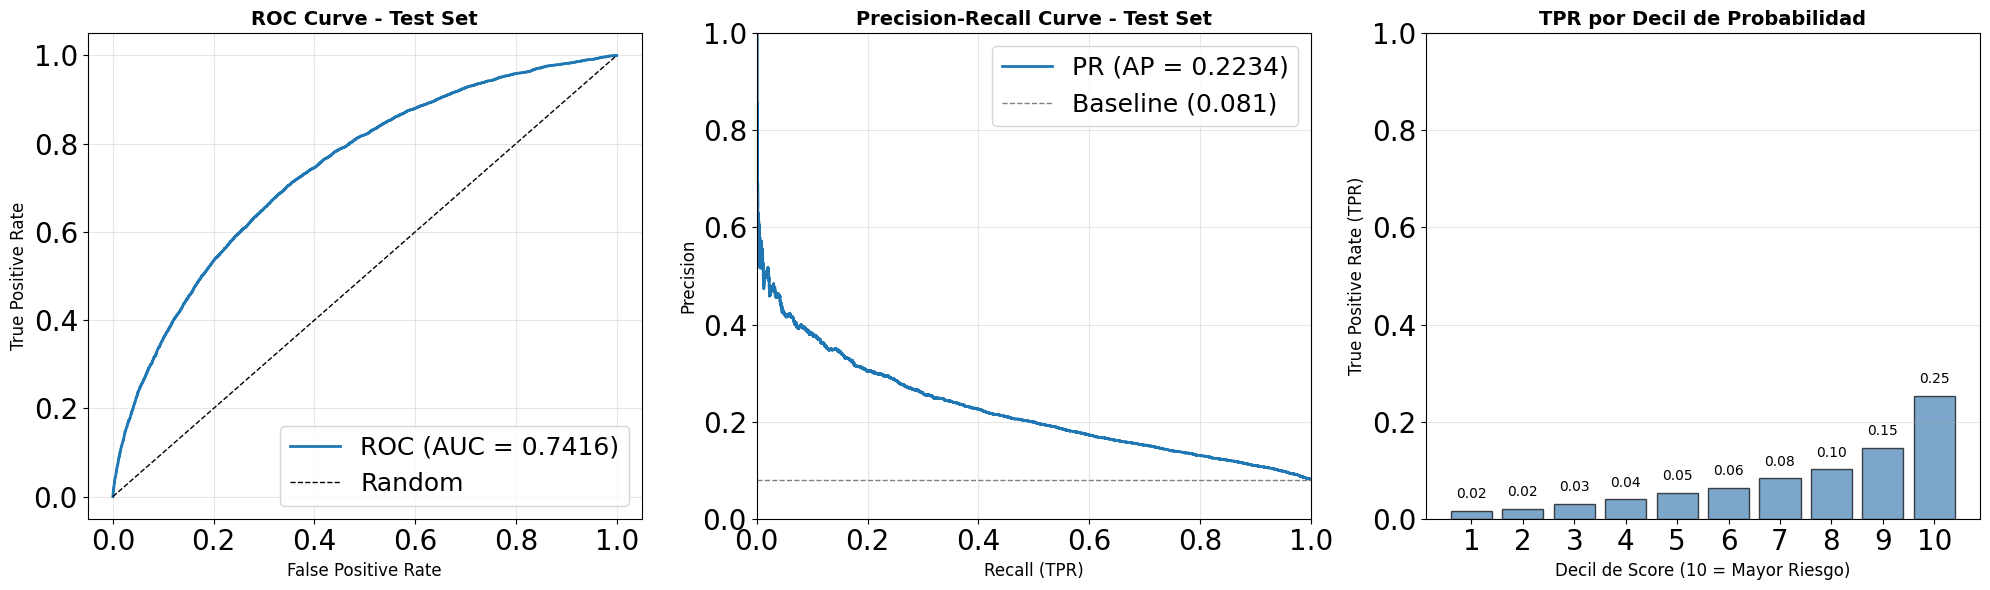

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
import pickle
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURACIÓN
# =============================================================================
TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5

print("="*80)
print("MODELO DE REGRESION LOGISTICA - HOME CREDIT DEFAULT RISK")
print("="*80)

# =============================================================================
# 1. VERIFICACIÓN DE DATOS
# =============================================================================
print("\n[1/15] Verificando datos existentes...")
print(f"Dataset en memoria: {df.shape}")
print(f"Usuarios: {len(df):,}")
print(f"Variables: {len(df.columns)}")
print(f"Tasa de default: {df['TARGET'].mean()*100:.2f}%")

# =============================================================================
# 2. PREPARACIÓN DE DATOS
# =============================================================================
print("\n[2/15] Preparando datos...")

X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

print(f"Variables predictoras: {X.shape[1]}")
print(f"Variable objetivo: {y.name}")

numeric_vars = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numericas: {len(numeric_vars)}")
print(f"Variables categoricas: {len(categorical_vars)}")

# =============================================================================
# 3. MANEJO DE VALORES FALTANTES
# =============================================================================
print("\n[3/15] Analizando valores faltantes...")

missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
missing_vars = missing_pct[missing_pct > 0]

if len(missing_vars) > 0:
    print(f"Variables con valores faltantes: {len(missing_vars)}")
    print(missing_vars.head(10))
    
    print("Imputando valores faltantes...")
    for col in numeric_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)
    
    for col in categorical_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].mode()[0], inplace=True)
    
    print("Valores faltantes imputados")
else:
    print("No hay valores faltantes")

# =============================================================================
# 4. CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# =============================================================================
print("\n[4/15] Codificando variables categoricas...")

label_encoders = {}

if len(categorical_vars) > 0:
    for col in categorical_vars:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    print(f"{len(categorical_vars)} variables codificadas")
    print(f"Categorias: {categorical_vars}")

# =============================================================================
# 5. DIVISIÓN TRAIN/TEST
# =============================================================================
print("\n[5/15] Dividiendo datos en Train/Test...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train set: {X_train.shape[0]:,} usuarios ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} usuarios ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribucion TARGET en Train:")
print(f"  Clase 0 (Pago): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Clase 1 (Default): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")

# =============================================================================
# 6. NORMALIZACIÓN
# =============================================================================
print("\n[6/15] Normalizando variables (StandardScaler)...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos normalizados (media=0, std=1)")
print(f"Media de features en train: {X_train_scaled.mean():.6f}")
print(f"Std de features en train: {X_train_scaled.std():.6f}")

# =============================================================================
# 7. ENTRENAMIENTO DEL MODELO
# =============================================================================
print("\n[7/15] Entrenando Regresion Logistica...")

model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

print("Modelo entrenado exitosamente")
print(f"Iteraciones: {model.n_iter_[0]}")
print(f"Clases: {model.classes_}")

# =============================================================================
# 8. VALIDACIÓN CRUZADA
# =============================================================================
print(f"\n[8/15] Validacion Cruzada ({CV_FOLDS}-fold en Train)...")

cv_scores = cross_val_score(
    model, X_train_scaled, y_train, 
    cv=CV_FOLDS, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC por fold: {cv_scores}")
print(f"Media: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# =============================================================================
# 9. PREDICCIONES
# =============================================================================
print("\n[9/15] Generando predicciones...")

y_train_pred = model.predict(X_train_scaled)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]

y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Predicciones generadas")

# =============================================================================
# 10. EVALUACIÓN EN TRAIN
# =============================================================================
print("\n[10/15] Evaluando modelo en TRAIN SET...")
print("="*80)

train_auc = roc_auc_score(y_train, y_train_proba)
train_ap = average_precision_score(y_train, y_train_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {train_auc:.4f}")
print(f"Average Precision: {train_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_train[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_train[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_train[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_train[1,1]:,} - Predijo 'Default' y si hizo default")

# =============================================================================
# 11. EVALUACIÓN EN TEST
# =============================================================================
print("\n[11/15] Evaluando modelo en TEST SET (metricas definitivas)...")
print("="*80)

test_auc = roc_auc_score(y_test, y_test_proba)
test_ap = average_precision_score(y_test, y_test_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {test_auc:.4f}")
print(f"Average Precision: {test_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_test[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_test[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_test[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_test[1,1]:,} - Predijo 'Default' y si hizo default")

# =============================================================================
# 12. COMPARACIÓN TRAIN VS TEST
# =============================================================================
print("\n[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...")
print("="*80)

print(f"\n{'Metrica':<25} {'Train':<12} {'Test':<12} {'Diferencia':<12}")
print("-" * 65)
print(f"{'ROC-AUC':<25} {train_auc:<12.4f} {test_auc:<12.4f} {abs(train_auc-test_auc):<12.4f}")
print(f"{'Average Precision':<25} {train_ap:<12.4f} {test_ap:<12.4f} {abs(train_ap-test_ap):<12.4f}")

diff_auc = abs(train_auc - test_auc)
if diff_auc < 0.02:
    print("\nExcelente generalizacion (diferencia < 2%)")
elif diff_auc < 0.05:
    print("\nBuena generalizacion (diferencia < 5%)")
elif diff_auc < 0.10:
    print("\nPosible ligero overfitting (diferencia 5-10%)")
else:
    print("\nOverfitting detectado (diferencia > 10%)")

# =============================================================================
# 13. IMPORTANCIA DE VARIABLES
# =============================================================================
print("\n[13/15] Calculando importancia de variables...")
print("="*80)

feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_[0],
    'Importancia_Abs': np.abs(model.coef_[0])
}).sort_values('Importancia_Abs', ascending=False)

print("\nTop 20 variables que mas influyen en el riesgo de default:\n")
print(feature_importance.head(20).to_string(index=False))

print("\nInterpretacion de coeficientes:")
print("  Coeficiente positivo (+): Aumenta probabilidad de DEFAULT")
print("  Coeficiente negativo (-): Disminuye probabilidad de DEFAULT")

# =============================================================================
# 14. VISUALIZACIONES
# =============================================================================
print("\n[14/15] Generando visualizaciones...")

# Calcular deciles
test_results = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_test_proba
})
test_results['decil'] = pd.qcut(test_results['y_proba'], q=10, labels=False, duplicates='drop') + 1

# Calcular TPR por decil
decil_stats = test_results.groupby('decil').agg({
    'y_true': ['sum', 'count', 'mean']
}).reset_index()
decil_stats.columns = ['decil', 'positivos', 'total', 'tpr']
decil_stats = decil_stats.sort_values('decil', ascending=False)

# Crear gráficas
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall Curve (Recall en X, Precision en Y)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

# Ordenar por recall ascendente para graficar correctamente
sort_idx = np.argsort(recall)
recall_sorted = recall[sort_idx]
precision_sorted = precision[sort_idx]

axes[1].plot(recall_sorted, precision_sorted, linewidth=2, label=f'PR (AP = {test_ap:.4f})')
axes[1].axhline(y=y_test.mean(), color='gray', linestyle='--', linewidth=1, label=f'Baseline ({y_test.mean():.3f})')
axes[1].set_xlabel('Recall (TPR)', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(alpha=0.3)

# TPR por Decil
axes[2].bar(decil_stats['decil'], decil_stats['tpr'], color='steelblue', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Decil de Score (10 = Mayor Riesgo)', fontsize=12)
axes[2].set_ylabel('True Positive Rate (TPR)', fontsize=12)
axes[2].set_title('TPR por Decil de Probabilidad', fontsize=14, fontweight='bold')
axes[2].set_xticks(range(1, 11))
axes[2].grid(alpha=0.3, axis='y')
axes[2].set_ylim(0, 1)

# Añadir valores en las barras
for i, row in decil_stats.iterrows():
    axes[2].text(row['decil'], row['tpr'] + 0.02, f"{row['tpr']:.2f}", 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('logistic_regression_curves.png', dpi=300, bbox_inches='tight')
print("Graficas guardadas: logistic_regression_curves.png")

# Imprimir tabla de deciles
print("\nTabla de TPR por Decil:")
print(decil_stats.to_string(index=False))

# =============================================================================
# 15. GUARDAR MODELO Y RESULTADOS
# =============================================================================
print("\n[15/15] Guardando modelo y resultados...")

with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

feature_importance.to_csv('feature_importance.csv', index=False)

test_predictions = pd.DataFrame({
    'SK_ID_CURR': df.iloc[X_test.index]['SK_ID_CURR'].values,
    'TARGET_Real': y_test.values,
    'TARGET_Predicho': y_test_pred,
    'Probabilidad_Default': y_test_proba
})
test_predictions.to_csv('test_predictions.csv', index=False)

print("Archivos guardados:")
print("  - logistic_model.pkl")
print("  - scaler.pkl")
print("  - label_encoders.pkl")
print("  - feature_importance.csv")
print("  - test_predictions.csv")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\n" + "="*80)
print("ANALISIS COMPLETADO")
print("="*80)
print(f"\nResultados Finales (TEST SET):")
print(f"  ROC-AUC: {test_auc:.4f}")
print(f"  Average Precision: {test_ap:.4f}")
print(f"  Accuracy: {(y_test_pred == y_test).mean():.4f}")
print(f"\nEl modelo esta listo para produccion")
print("="*80)

In [14]:
# Ver distribución de probabilidades predichas
print("Estadísticas de probabilidades predichas:")
print(f"Min: {y_test_proba.min():.4f}")
print(f"Max: {y_test_proba.max():.4f}")
print(f"Media: {y_test_proba.mean():.4f}")
print(f"Mediana: {np.median(y_test_proba):.4f}")
print(f"\nCuántos tienen proba > 0.5: {(y_test_proba > 0.5).sum()}")
print(f"Cuántos tienen proba > 0.1: {(y_test_proba > 0.1).sum()}")

Estadísticas de probabilidades predichas:
Min: 0.0006
Max: 0.9871
Media: 0.4261
Mediana: 0.4014

Cuántos tienen proba > 0.5: 20972
Cuántos tienen proba > 0.1: 60924


MODELO DE REGRESION LOGISTICA CON SMOTE - HOME CREDIT DEFAULT RISK

[1/16] Verificando datos existentes...
Dataset en memoria: (307511, 41)
Usuarios: 307,511
Variables: 41
Tasa de default: 8.07%

[2/16] Preparando datos...
Variables predictoras: 39
Variable objetivo: TARGET
Variables numericas: 34
Variables categoricas: 5

[3/16] Analizando valores faltantes...
Variables con valores faltantes: 10
TASA_INTERES_PROMEDIO   98.501
RATIO_PAGO_MINIMO_TC    80.726
EXT_SOURCE_1            56.381
EXT_SOURCE_3            19.825
PLAZO_PROMEDIO           5.486
RATIO_PAGO_CUOTA         5.164
EXT_SOURCE_2             0.215
SCORE_PROMEDIO           0.056
AMT_ANNUITY              0.004
CNT_FAM_MEMBERS          0.001
dtype: float64
Imputando valores faltantes...
Valores faltantes imputados

[4/16] Codificando variables categoricas...
5 variables codificadas
Categorias: ['NAME_FAMILY_STATUS', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

[5/16] Dividiendo datos en Train/Test.

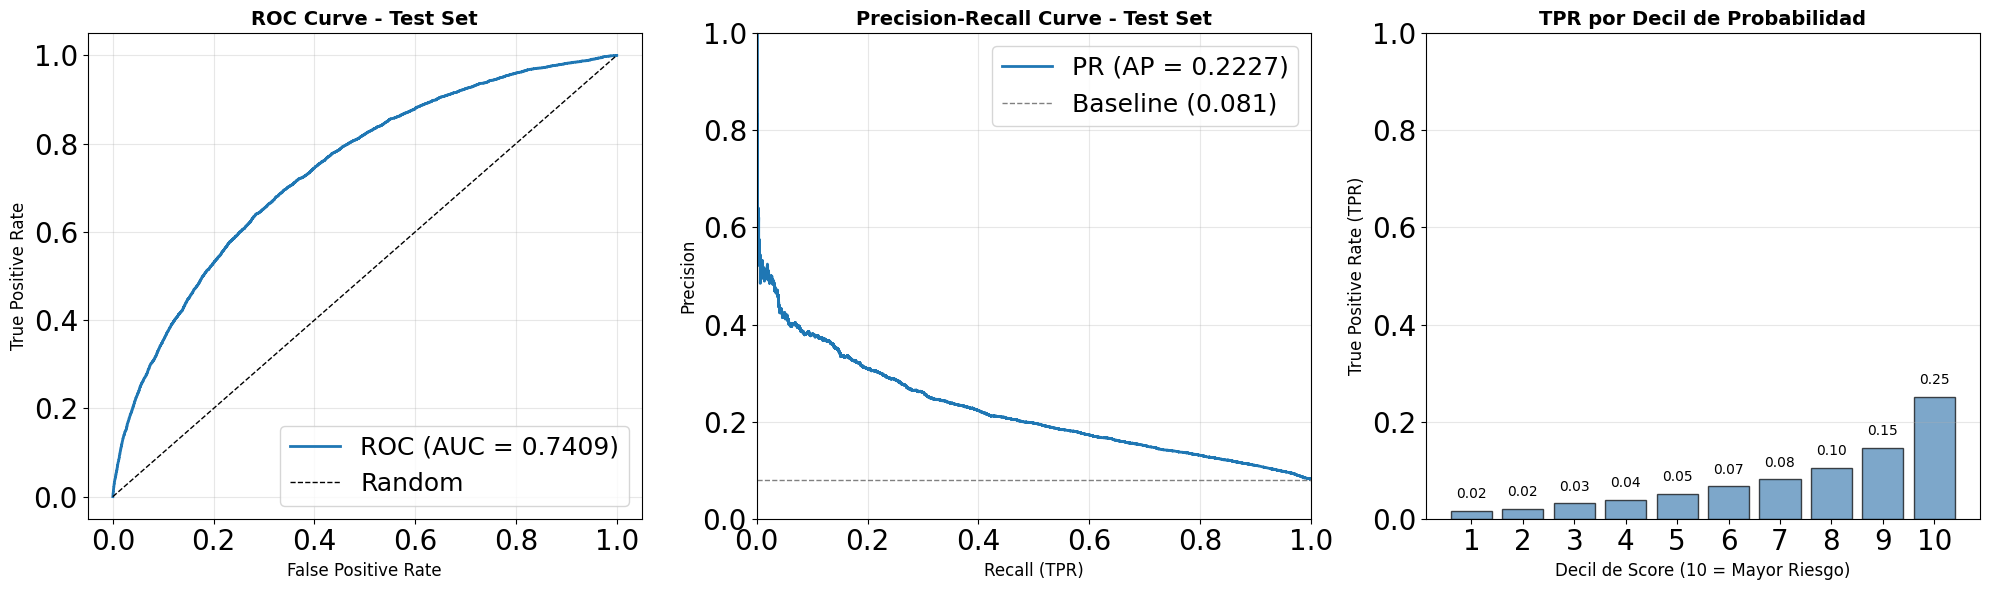

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE
import pickle
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURACIÓN
# =============================================================================
TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5

print("="*80)
print("MODELO DE REGRESION LOGISTICA CON SMOTE - HOME CREDIT DEFAULT RISK")
print("="*80)

# =============================================================================
# 1. VERIFICACIÓN DE DATOS
# =============================================================================
print("\n[1/16] Verificando datos existentes...")
print(f"Dataset en memoria: {df.shape}")
print(f"Usuarios: {len(df):,}")
print(f"Variables: {len(df.columns)}")
print(f"Tasa de default: {df['TARGET'].mean()*100:.2f}%")

# =============================================================================
# 2. PREPARACIÓN DE DATOS
# =============================================================================
print("\n[2/16] Preparando datos...")

X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

print(f"Variables predictoras: {X.shape[1]}")
print(f"Variable objetivo: {y.name}")

numeric_vars = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numericas: {len(numeric_vars)}")
print(f"Variables categoricas: {len(categorical_vars)}")

# =============================================================================
# 3. MANEJO DE VALORES FALTANTES
# =============================================================================
print("\n[3/16] Analizando valores faltantes...")

missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
missing_vars = missing_pct[missing_pct > 0]

if len(missing_vars) > 0:
    print(f"Variables con valores faltantes: {len(missing_vars)}")
    print(missing_vars.head(10))
    
    print("Imputando valores faltantes...")
    for col in numeric_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)
    
    for col in categorical_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].mode()[0], inplace=True)
    
    print("Valores faltantes imputados")
else:
    print("No hay valores faltantes")

# =============================================================================
# 4. CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# =============================================================================
print("\n[4/16] Codificando variables categoricas...")

label_encoders = {}

if len(categorical_vars) > 0:
    for col in categorical_vars:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    print(f"{len(categorical_vars)} variables codificadas")
    print(f"Categorias: {categorical_vars}")

# =============================================================================
# 5. DIVISIÓN TRAIN/TEST
# =============================================================================
print("\n[5/16] Dividiendo datos en Train/Test...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train set: {X_train.shape[0]:,} usuarios ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} usuarios ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribucion TARGET en Train (ORIGINAL):")
print(f"  Clase 0 (Pago): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Clase 1 (Default): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")

# =============================================================================
# 6. NORMALIZACIÓN
# =============================================================================
print("\n[6/16] Normalizando variables (StandardScaler)...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos normalizados (media=0, std=1)")
print(f"Media de features en train: {X_train_scaled.mean():.6f}")
print(f"Std de features en train: {X_train_scaled.std():.6f}")

# =============================================================================
# 7. APLICAR SMOTE (BALANCEO)
# =============================================================================
print("\n[7/16] Aplicando SMOTE para balancear clases...")

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nDistribucion TARGET en Train (DESPUES DE SMOTE):")
print(f"  Clase 0 (Pago): {(y_train_balanced==0).sum():,} ({(y_train_balanced==0).sum()/len(y_train_balanced)*100:.2f}%)")
print(f"  Clase 1 (Default): {(y_train_balanced==1).sum():,} ({(y_train_balanced==1).sum()/len(y_train_balanced)*100:.2f}%)")
print(f"\nTrain set balanceado: {X_train_balanced.shape[0]:,} usuarios (incremento: {X_train_balanced.shape[0] - X_train_scaled.shape[0]:,})")

# =============================================================================
# 8. ENTRENAMIENTO DEL MODELO
# =============================================================================
print("\n[8/16] Entrenando Regresion Logistica con datos balanceados...")

model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model.fit(X_train_balanced, y_train_balanced)

print("Modelo entrenado exitosamente")
print(f"Iteraciones: {model.n_iter_[0]}")
print(f"Clases: {model.classes_}")

# =============================================================================
# 9. VALIDACIÓN CRUZADA
# =============================================================================
print(f"\n[9/16] Validacion Cruzada ({CV_FOLDS}-fold en Train balanceado)...")

cv_scores = cross_val_score(
    model, X_train_balanced, y_train_balanced, 
    cv=CV_FOLDS, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC por fold: {cv_scores}")
print(f"Media: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# =============================================================================
# 10. PREDICCIONES
# =============================================================================
print("\n[10/16] Generando predicciones...")

y_train_pred = model.predict(X_train_scaled)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]

y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Predicciones generadas")

# =============================================================================
# 11. EVALUACIÓN EN TRAIN
# =============================================================================
print("\n[11/16] Evaluando modelo en TRAIN SET (original, no balanceado)...")
print("="*80)

train_auc = roc_auc_score(y_train, y_train_proba)
train_ap = average_precision_score(y_train, y_train_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {train_auc:.4f}")
print(f"Average Precision: {train_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_train[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_train[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_train[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_train[1,1]:,} - Predijo 'Default' y si hizo default")

# =============================================================================
# 12. EVALUACIÓN EN TEST
# =============================================================================
print("\n[12/16] Evaluando modelo en TEST SET (metricas definitivas)...")
print("="*80)

test_auc = roc_auc_score(y_test, y_test_proba)
test_ap = average_precision_score(y_test, y_test_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {test_auc:.4f}")
print(f"Average Precision: {test_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_test[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_test[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_test[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_test[1,1]:,} - Predijo 'Default' y si hizo default")

# =============================================================================
# 13. COMPARACIÓN TRAIN VS TEST
# =============================================================================
print("\n[13/16] Comparando TRAIN vs TEST (analisis de overfitting)...")
print("="*80)

print(f"\n{'Metrica':<25} {'Train':<12} {'Test':<12} {'Diferencia':<12}")
print("-" * 65)
print(f"{'ROC-AUC':<25} {train_auc:<12.4f} {test_auc:<12.4f} {abs(train_auc-test_auc):<12.4f}")
print(f"{'Average Precision':<25} {train_ap:<12.4f} {test_ap:<12.4f} {abs(train_ap-test_ap):<12.4f}")

diff_auc = abs(train_auc - test_auc)
if diff_auc < 0.02:
    print("\nExcelente generalizacion (diferencia < 2%)")
elif diff_auc < 0.05:
    print("\nBuena generalizacion (diferencia < 5%)")
elif diff_auc < 0.10:
    print("\nPosible ligero overfitting (diferencia 5-10%)")
else:
    print("\nOverfitting detectado (diferencia > 10%)")

# =============================================================================
# 14. IMPORTANCIA DE VARIABLES
# =============================================================================
print("\n[14/16] Calculando importancia de variables...")
print("="*80)

feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_[0],
    'Importancia_Abs': np.abs(model.coef_[0])
}).sort_values('Importancia_Abs', ascending=False)

print("\nTop 20 variables que mas influyen en el riesgo de default:\n")
print(feature_importance.head(20).to_string(index=False))

print("\nInterpretacion de coeficientes:")
print("  Coeficiente positivo (+): Aumenta probabilidad de DEFAULT")
print("  Coeficiente negativo (-): Disminuye probabilidad de DEFAULT")

# =============================================================================
# 15. VISUALIZACIONES
# =============================================================================
print("\n[15/16] Generando visualizaciones...")

# Calcular deciles
test_results = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_test_proba
})
test_results['decil'] = pd.qcut(test_results['y_proba'], q=10, labels=False, duplicates='drop') + 1

# Calcular TPR por decil
decil_stats = test_results.groupby('decil').agg({
    'y_true': ['sum', 'count', 'mean']
}).reset_index()
decil_stats.columns = ['decil', 'positivos', 'total', 'tpr']
decil_stats = decil_stats.sort_values('decil', ascending=False)

# Crear gráficas
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

sort_idx = np.argsort(recall)
recall_sorted = recall[sort_idx]
precision_sorted = precision[sort_idx]

axes[1].plot(recall_sorted, precision_sorted, linewidth=2, label=f'PR (AP = {test_ap:.4f})')
axes[1].axhline(y=y_test.mean(), color='gray', linestyle='--', linewidth=1, label=f'Baseline ({y_test.mean():.3f})')
axes[1].set_xlabel('Recall (TPR)', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(alpha=0.3)

# TPR por Decil
axes[2].bar(decil_stats['decil'], decil_stats['tpr'], color='steelblue', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Decil de Score (10 = Mayor Riesgo)', fontsize=12)
axes[2].set_ylabel('True Positive Rate (TPR)', fontsize=12)
axes[2].set_title('TPR por Decil de Probabilidad', fontsize=14, fontweight='bold')
axes[2].set_xticks(range(1, 11))
axes[2].grid(alpha=0.3, axis='y')
axes[2].set_ylim(0, 1)

for i, row in decil_stats.iterrows():
    axes[2].text(row['decil'], row['tpr'] + 0.02, f"{row['tpr']:.2f}", 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('logistic_regression_smote_curves.png', dpi=300, bbox_inches='tight')
print("Graficas guardadas: logistic_regression_smote_curves.png")

print("\nTabla de TPR por Decil:")
print(decil_stats.to_string(index=False))

# =============================================================================
# 16. GUARDAR MODELO Y RESULTADOS
# =============================================================================
print("\n[16/16] Guardando modelo y resultados...")

with open('logistic_model_smote.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

feature_importance.to_csv('feature_importance_smote.csv', index=False)

test_predictions = pd.DataFrame({
    'SK_ID_CURR': df.iloc[X_test.index]['SK_ID_CURR'].values,
    'TARGET_Real': y_test.values,
    'TARGET_Predicho': y_test_pred,
    'Probabilidad_Default': y_test_proba
})
test_predictions.to_csv('test_predictions_smote.csv', index=False)

print("Archivos guardados:")
print("  - logistic_model_smote.pkl")
print("  - scaler.pkl")
print("  - label_encoders.pkl")
print("  - feature_importance_smote.csv")
print("  - test_predictions_smote.csv")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\n" + "="*80)
print("ANALISIS COMPLETADO CON SMOTE")
print("="*80)
print(f"\nResultados Finales (TEST SET):")
print(f"  ROC-AUC: {test_auc:.4f}")
print(f"  Average Precision: {test_ap:.4f}")
print(f"  Accuracy: {(y_test_pred == y_test).mean():.4f}")
print(f"\nEl modelo con SMOTE esta listo para produccion")
print("="*80)